In [2]:
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from tqdm import tqdm
from IPython.display import display

## Setup

Setting up the necessary variables which will be used in future cells.
There are two different indexes referenced in this notebook.

- **c-user-pb5253-dev-2023-11-01**: Is an index that utilized semantic search and has prioritized content consisting of BOTH content and metadata.
- **c-care-cog-dev-2023-10-25**: Is an index that utilized semantic search and has prioritized content consisting of ONLY content.

Before running this cell, make sure to copy the `sample.env` file into `.env`. Make sure to set the values:

- **AZURE_COGNITIVE_SEARCH_API_KEY**: The azure cognitive search api key for the cognitive search instance **searchcast-nprd-33435-southcentralus**.

In [3]:
# creating the paths
OUTPUT_PATH = "./output"
INPUT_PATH = "./input"

os.makedirs(OUTPUT_PATH, exist_ok=True)

# creating the variables to interface with cognitive search
load_dotenv('./.env')

default_body = {
    "debug": "semantic",
    "queryType": "semantic",
    "semanticConfiguration": "<semantic-config-name>",
    "search": "",
    "queryLanguage": "en-us",
    "answers": "extractive",
    "select": "content,metadata",
    "top": 10,
    "captions": "extractive",
    "vectorQueries": [
        {
            "kind": "vector",
            "k": 50,
            "fields": "content_vector",
            "vector": np.ones(768).tolist()
        }
    ]
}
url_template = "https://searchcast-nprd-33435-southcentralus.search.windows.net//indexes('{index_name}')/docs/search.post.search?api-version=2023-10-01-Preview"
api_key = os.environ.get("AZURE_COGNITIVE_SEARCH_API_KEY")
if not api_key:
    raise ValueError("AZURE_COGNITIVE_SEARCH_API_KEY not set.")

semantic_with_metadata_index_name = "c-user-pb5253-dev-2023-11-01"
semantic_without_metadata_index_name = "c-care-cog-dev-2023-10-25"

ground_truth_df = pd.read_csv(os.path.join(INPUT_PATH, 'ground_truth.csv'))
questions = ground_truth_df['bcss_question'].values

## Getting the Embeddings of all Ground Truth Questions

We will leverage the questions and the embeddings of the questions in a future cell.
Here we are getting the embeddings of all the questions and saving them for later use.

In [4]:
DOMAIN_SERVICES_URL_GET_CHUNKS = "https://askapi.dev.att.com/automation/domain-services/get_embedding_chunks"

def get_embeddings(questions: list[str]):
    question_map = {f"{i}": { "id": f"{i}", "text": question } for i, question in enumerate(questions)}
    question_map.items
    body = {
        "domain": "user_pb5253",
        "config_version": "2023-11-01",
        "data": [{"id": k, "text": v["text"]} for k, v in question_map.items()]
    }

    res = requests.post(
        url=DOMAIN_SERVICES_URL_GET_CHUNKS,
        json=body
    )
    res.raise_for_status()
    res_json = res.json()
    for result in res_json:
        question_map[result["id"]]["embedding"] = result["embedding"]
    return list(question_map.values())

embedding_output_file_path = os.path.join(OUTPUT_PATH, "embedding.json")
if not os.path.exists(embedding_output_file_path):
    result = get_embeddings(questions)
    with open(embedding_output_file_path, "w") as f:
        json.dump(result, f)

## Fetching Semantic Results

In [5]:
def perform_pseudo_similarity_search(
    index_name: str,
    semantic_configuration_name: str,
    text: str,
    embedding: list[float],
    top: int = 10
):
    headers = {
        'api-key': api_key,
        'Content-Type': 'application/json'
    }

    body = default_body.copy()
    body['semanticConfiguration'] = semantic_configuration_name
    body['search'] = text
    body['top'] = top
    body['vectorQueries'][0]['vector'] = embedding
    url = url_template.format(index_name=index_name)

    res = requests.post(
        url=url,
        json=body,
        headers=headers
    )
    return res.json()

# read the embeddings
with open(embedding_output_file_path, "r") as f:
    embeddings = json.load(f)

first_record = embeddings[0]
text = first_record["text"]
embedding = first_record["embedding"]
id = first_record["id"]

semantic_with_metadata_output_file_name = f"{semantic_with_metadata_index_name}-{id}.json"
semantic_with_metadata_output_file_path = os.path.join(OUTPUT_PATH, semantic_with_metadata_output_file_name)
semantic_without_metadata_output_file_name = f"{semantic_without_metadata_index_name}-{id}.json"
semantic_without_metadata_output_file_path = os.path.join(OUTPUT_PATH, semantic_without_metadata_output_file_name)

if not os.path.exists(semantic_with_metadata_output_file_path):
    semantic_with_metadata_data = perform_pseudo_similarity_search(
        semantic_with_metadata_index_name,
        "semantic_config",
        text,
        embedding
    )
    with open(semantic_with_metadata_output_file_path, "w") as f:
        json.dump(semantic_with_metadata_data, f)

if not os.path.exists(semantic_without_metadata_output_file_path):    
    semantic_without_metadata_data = perform_pseudo_similarity_search(
        semantic_without_metadata_index_name,
        "semantic_configuration",
        text,
        embedding
    )
    with open(semantic_without_metadata_output_file_path, "w") as f:
        json.dump(semantic_without_metadata_data, f)

In [6]:
def display_semantic_search_sample(semantic_result: dict):
    values = semantic_result["value"]
    first_value = values[0]
    print(json.dumps(first_value, indent=2))

with open(semantic_with_metadata_output_file_path, "r") as f:
    semantic_with_metadata_data = json.load(f)

with open(semantic_without_metadata_output_file_path, "r") as f:
    semantic_without_metadata_data = json.load(f)

### Results for Semantic Settings with Content and Metadata

The cell below displays the top result for the semantic configuration with content and metadata.

In [7]:
display_semantic_search_sample(semantic_with_metadata_data)

{
  "@search.score": 0.02829820290207863,
  "@search.rerankerScore": 3.3956801891326904,
  "@search.captions": [
    {
      "text": "What international benefits are included in the AT&T unlimited plans?With Unlimited Starter, Extra and Premium plans, you can text from the U.S. to\u00a0200+ countries \u00a0and make unlimited calls from the U.S. to Mexico and Canada. You can also talk, text, and use data in Mexico and Canada for no additional roaming charge.",
      "highlights": ""
    }
  ],
  "@search.documentDebugInfo": {
    "semantic": {
      "titleField": null,
      "contentFields": [
        {
          "name": "content",
          "state": "used"
        },
        {
          "name": "metadata",
          "state": "used"
        }
      ],
      "keywordFields": [],
      "rerankerInput": {
        "title": null,
        "content": "Are there any other data plan options for my tablet?Yes. You can add a tablet to your Unlimited Starter, Extra or Premium plan for $20/mo. In ad

### Results for Semantic Settings with only Content

The cell below displays the top result for the semantic configuration with only content.

In [8]:
display_semantic_search_sample(semantic_without_metadata_data)

{
  "@search.score": 0.028033792972564697,
  "@search.rerankerScore": 3.3956801891326904,
  "@search.captions": [
    {
      "text": "What international benefits are included in the AT&T unlimited plans?With Unlimited Starter, Extra and Premium plans, you can text from the U.S. to\u00a0200+ countries \u00a0and make unlimited calls from the U.S. to Mexico and Canada. You can also talk, text, and use data in Mexico and Canada for no additional roaming charge.",
      "highlights": ""
    }
  ],
  "@search.documentDebugInfo": {
    "semantic": {
      "titleField": null,
      "contentFields": [
        {
          "name": "content",
          "state": "used"
        }
      ],
      "keywordFields": [],
      "rerankerInput": {
        "title": null,
        "content": "Are there any other data plan options for my tablet?Yes. You can add a tablet to your Unlimited Starter, Extra or Premium plan for $20/mo. In addition, AT&T DataConnect plans, with access to nationwide AT&T 5G at no addi

## First Pass Analysis

The key metrics for the experiment are the following:

| Experiment Name | Experiment Id | init_rougeL_recall_median | in_top_init_% |
| --- | --- | --- | --- |
| Experiment 1 | 43aa858c-a86b-4ff8-afcf-c3992f965527 | 0.804740957966764 | 0.637295081967213 |
| Experiment 2 | 0f6f936f-a8a8-483d-b7c2-61ff884c95ae | 0.80896751223854 | 0.64139344262295 |
| Experiment 3 | 1f510891-700b-438b-a377-08f5bf460d69 | 0.808051761322789 | 0.64139344262295 |

Where:

- Experiment 1 (43aa858c-a86b-4ff8-afcf-c3992f965527): Azure Cognitive Search with Semantic Search on the content field
- Experiment 2 (0f6f936f-a8a8-483d-b7c2-61ff884c95ae): Azure Cognitive Search with Semantic Search on the content and metadata field **(order=content,metadata)**
- Experiment 3 (1f510891-700b-438b-a377-08f5bf460d69): Azure Cognitive Search with Semantic Search on the content and metadata field **(order=metadata,content)**

For the case of the analysis, we will only analyze experiments 1 and 2 as the results for experiment 2 and 3 are very similar.

**NOTE:** The only difference between experiment 2 and 3 is the order of the content.

By running semantic search on the different index configurations, we the result and the scores are about the same given the search query and embedding vector.
Let's try to figure out what is going on and ensure things are configured properly.

### Is Configuration Correct?

We can see that the configuration we have for semantic with content and metadata is leveraging the expected fields to construct the input into the semantic search process.
This can be seen from the definition of both **content** and **medatadata** in the JSON object of `@search.documentDebugInfo[0].semantic.contentFields`.
We can also see that `@search.documentDebugInfo.semantic.rerankerInput.content` contains the concatenated string of the content and metadata.
We can see that the result for the configuration we have for semantic with only content is only leveraging the **content** field when constructing the input into the semantic search flow.

One interesting thing to note is the scores are also identical.
Let's analyze the distribution of the overlapping of the chunks on a per query basis to see if this stringified approach varied the chunks any.

## Analysis of Chunks

Let's analyze how similar the chunks are between the configuration with metadata and the configuration without metadata.
For this analysis, we will take the intersection of the content returned from search for both the configuration with metadata and the configuration without metadata.

### Fetching Top 20

We plan on fetching the top 20 from the index corresponding from experiment 1 and experiment 2.
We will then analyze the chunks that overlap on a per question basis to get an understanding of how similar (or different) the semantic search results are.

In [9]:
def get_content_from_semantic_search_results(semantic_search_result: dict):
    values: list[dict] = semantic_search_result.get("value")
    content = [value['content'] for value in values]
    return content

def get_scores_from_semantic_search_results(semantic_search_result: dict):
    values: list[dict] = semantic_search_result.get("value")
    scores = [value['@search.score'] for value in values]
    reranker_scores = [value['@search.rerankerScore'] for value in values]
    return scores, reranker_scores

question_embeddings = []
with open(embedding_output_file_path, "r") as f:
    question_embeddings = json.load(f)

SEARCH_TOP = 20
semantic_with_metadata_results = []
semantic_without_metadata_results = []
for question in tqdm(question_embeddings):
    text = question['text']
    embedding = question['embedding']
    semantic_with_metadata_data = perform_pseudo_similarity_search(
        semantic_with_metadata_index_name,
        "semantic_config",
        text,
        embedding,
        SEARCH_TOP
    )
    semantic_with_metadata_results.append((text, semantic_with_metadata_data))

    semantic_without_metadata_data = perform_pseudo_similarity_search(
        semantic_without_metadata_index_name,
        "semantic_configuration",
        text,
        embedding,
        SEARCH_TOP
    )
    semantic_without_metadata_results.append((text, semantic_without_metadata_data))

100%|██████████| 500/500 [17:19<00:00,  2.08s/it]


In [94]:
def filter_by_top_k(result: dict, top: int) -> dict:
    result_copy = result.copy()
    result_copy['value'] = result_copy['value'][:top]
    return result_copy

def compare_question_results(with_metadata: list[tuple[str, dict]], without_metadata: list[tuple[str, dict]], top: int):
    question_matching_count_map = {}
    for with_metadata_elem, without_metadata_elem in tqdm(zip(with_metadata, without_metadata)):
        with_metadata_text, with_metadata_search_results = with_metadata_elem
        without_metadata_text, without_metadata_search_results = without_metadata_elem

        # asserting we are comparing the same questions
        assert with_metadata_text == without_metadata_text

        with_metadata_search_results = filter_by_top_k(with_metadata_search_results, top)
        without_metadata_search_results = filter_by_top_k(without_metadata_search_results, top)

        with_metadata_content = get_content_from_semantic_search_results(with_metadata_search_results)
        without_metadata_content = get_content_from_semantic_search_results(without_metadata_search_results)

        matching_content_count = 0
        for elem in with_metadata_content:
            if elem in without_metadata_content:
                matching_content_count += 1

        question_matching_count_map[with_metadata_text] = matching_content_count
    return {
        "results": question_matching_count_map,
        "top": top
    }
    
content_similarity_20_result = compare_question_results(semantic_with_metadata_results, semantic_without_metadata_results, SEARCH_TOP)
content_similarity_20_arr = list(content_similarity_20_result["results"].values())

500it [00:00, 27779.06it/s]



Results of Chunk Similarity
Mean: 17.866666666666667;
Percent Overlap: 89.33333333333333;
Median: 18.0;
75th Percentile: 19.0;
IQR: 2.0;
Min: 10;
Max: 20;
STD: 1.5564788024982104;



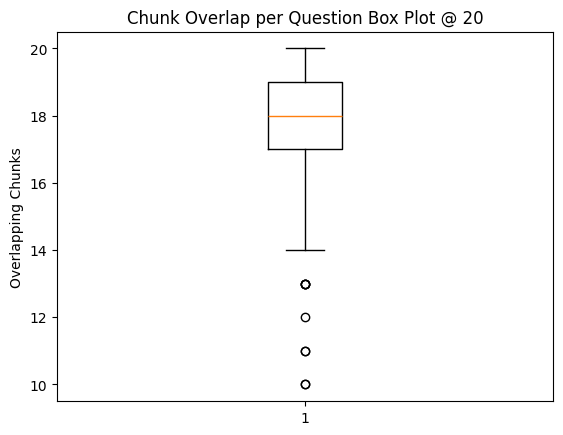

In [112]:
q75, q25 = np.percentile(content_similarity_20_arr, [75 ,25])
mean_content_similarity = np.mean(content_similarity_20_arr)
median_content_similarity = np.median(content_similarity_20_arr)
min_content_similarity = min(content_similarity_20_arr)
max_content_similarity = max(content_similarity_20_arr)
variance_content_similarity = np.std(content_similarity_20_arr)
print(f"""
Results of Chunk Similarity
Mean: {mean_content_similarity};
Percent Overlap: {mean_content_similarity/20*100};
Median: {median_content_similarity};
75th Percentile: {q75};
IQR: {q75 - q25};
Min: {min_content_similarity};
Max: {max_content_similarity};
STD: {variance_content_similarity};
""")

# creating a box and whiskers plot
fig, ax = plt.subplots()
ax.boxplot(content_similarity_20_arr)
ax.set_ylabel("Overlapping Chunks")
ax.set_title("Chunk Overlap per Question Box Plot @ 20")
plt.show()

## Top 10

In [96]:
content_similarity_10_result = compare_question_results(semantic_with_metadata_results, semantic_without_metadata_results, 10)
content_similarity_10_arr = list(content_similarity_10_result["results"].values())

500it [00:00, 61016.93it/s]



Results of Chunk Similarity
Mean: 8.886868686868686;
Percent Overlap: 88.86868686868686;
Median: 9.0;
75th Percentile: 10.0;
IQR: 2.0;
Min: 4;
Max: 10;



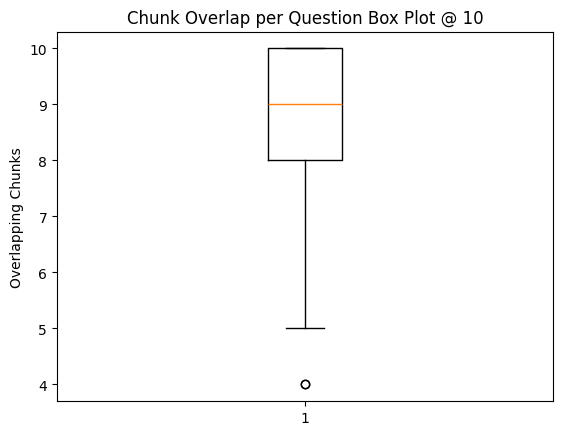

In [113]:
q75, q25 = np.percentile(content_similarity_10_arr, [75 ,25])
mean_content_similarity = np.mean(content_similarity_10_arr)
median_content_similarity = np.median(content_similarity_10_arr)
min_content_similarity = min(content_similarity_10_arr)
max_content_similarity = max(content_similarity_10_arr)
print(f"""
Results of Chunk Similarity
Mean: {mean_content_similarity};
Percent Overlap: {mean_content_similarity/10*100};
Median: {median_content_similarity};
75th Percentile: {q75};
IQR: {q75 - q25};
Min: {min_content_similarity};
Max: {max_content_similarity};
""")

# creating a box and whiskers plot
fig, ax = plt.subplots()
ax.boxplot(content_similarity_10_arr)
ax.set_ylabel("Overlapping Chunks")
ax.set_title("Chunk Overlap per Question Box Plot @ 10")
plt.show()

## Top 5

In [98]:
content_similarity_5_result = compare_question_results(semantic_with_metadata_results, semantic_without_metadata_results, 5)
content_similarity_5_arr = list(content_similarity_5_result["results"].values())

500it [00:00, 100035.87it/s]



Results of Chunk Similarity
Mean: 4.3717171717171714;
Percent Overlap: 87.43434343434343;
Median: 5.0;
75th Percentile: 5.0;
IQR: 1.0;
Min: 1;
Max: 5;



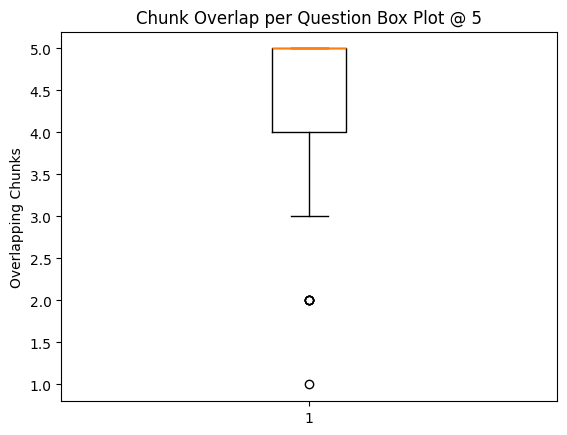

In [114]:
q75, q25 = np.percentile(content_similarity_5_arr, [75 ,25])
mean_content_similarity = np.mean(content_similarity_5_arr)
median_content_similarity = np.median(content_similarity_5_arr)
min_content_similarity = min(content_similarity_5_arr)
max_content_similarity = max(content_similarity_5_arr)
print(f"""
Results of Chunk Similarity
Mean: {mean_content_similarity};
Percent Overlap: {mean_content_similarity/5*100};
Median: {median_content_similarity};
75th Percentile: {q75};
IQR: {q75 - q25};
Min: {min_content_similarity};
Max: {max_content_similarity};
""")

# creating a box and whiskers plot
fig, ax = plt.subplots()
ax.boxplot(content_similarity_5_arr)
ax.set_ylabel("Overlapping Chunks")
ax.set_title("Chunk Overlap per Question Box Plot @ 5")
plt.show()

## Sampling Results with Higher Discrepancies

Let's analyze some of the questions that have a lower number of similar chunks.
From this analysis, we will later see if hte scores are higher, lower, or similar between the semantic similarity with metadata vs without metadata.
This analysis will be performed on the to 20 chunks from cognitive search as the search results are analyzed on the to 20 chunks.

In [26]:
q25 = np.percentile(content_similarity_20_arr, [25])[0]
bottom_20_questions = {elem[0]: elem[1] for elem in content_similarity_20_result['results'].items() if elem[1] <= q25}
print(json.dumps(bottom_20_questions, indent=2))

{
  "What countries are eligible for the International Day Pass?": 17,
  "How long must an account be active in order to complete a ToBR?": 16,
  "What are the different caller access levels for? ": 16,
  "Am I required to send a one-time pin for an add a line request for an Enhanced Care customer?": 17,
  "What additional information do I need for a PIN pass customer? ": 17,
  "Can I add a line to the AT&T Mobile Share Plus for Business? ": 17,
  "When does daylight savings ends?": 17,
  "What is one-time pin?": 17,
  "What can I use FaST for?": 14,
  "What can AOP's do?": 16,
  "What is CareNow?": 17,
  "How do I contact the language line?": 15,
  "What is CNAM?": 17,
  "Where is Ozmo located? ": 14,
  "What are the details for Business International Calling?": 17,
  "How do I login into SOE?": 15,
  "Where can I report issues with CTI?": 17,
  "What are fraud red flags?": 16,
  "How do I Blacklist a stolen device? ": 17,
  "\n\nWhat is a PUK code? ": 16,
  "What funtionalities are a

In [49]:
def get_metrics_for_subset_of_results(df: pd.DataFrame, experiment_note: str):
    all_metrics_dict = {}

    # in top init percent
    num_rows_with_source = len(df[(df['source_missing'] == False) | df['source']])
    all_metrics_dict[f'in_top_init_%'] = (len(df[df['in_top_init']>0]) / num_rows_with_source)

    # init rougeL recall median
    all_metrics_dict['init_rougeL_recall_median'] = df['init_rougeL_recall'].median()
    all_metrics_dict['init_rougeL_recall_std'] = df['init_rougeL_recall'].std()
    all_metrics_dict['init_rougeL_recall_max'] = df['init_rougeL_recall'].max()
    all_metrics_dict['init_rougeL_recall_min'] = df['init_rougeL_recall'].min()

    all_metrics_dict['percent_with_source'] = num_rows_with_source / len(df)
    all_metrics_dict['experiment_note'] = experiment_note
    metrics_df = pd.DataFrame(all_metrics_dict, index=[0])
    return metrics_df

bottom_25_questions_str_arr = list(bottom_20_questions.keys())
experiment1_df = pd.read_csv(os.path.join(INPUT_PATH, '43aa858c-a86b-4ff8-afcf-c3992f965527-result.csv'))
experiment1_bottom_25_df = experiment1_df[experiment1_df['bcss_question'].isin(bottom_25_questions_str_arr)]
experiment1_bottom_25_metrics_df = get_metrics_for_subset_of_results(experiment1_bottom_25_df, "Bottom 25%")
experiment1_top_75_df = experiment1_df[~experiment1_df['bcss_question'].isin(bottom_25_questions_str_arr)]
experiment1_top_75_metrics_df = get_metrics_for_subset_of_results(experiment1_top_75_df, "Top 75%")
experiment_1_metrics_df = pd.concat([experiment1_bottom_25_metrics_df, experiment1_top_75_metrics_df])

experiment2_df = pd.read_csv(os.path.join(INPUT_PATH, '01592642-4936-41dc-a516-c296813c972d-result.csv'))
experiment2_bottom_25_df = experiment2_df[experiment2_df['bcss_question'].isin(bottom_25_questions_str_arr)]
experiment2_bottom_25_metrics_df = get_metrics_for_subset_of_results(experiment2_bottom_25_df, "Bottom 25%")
experiment2_top_75_df = experiment2_df[~experiment2_df['bcss_question'].isin(bottom_25_questions_str_arr)]
experiment2_top_75_metrics_df = get_metrics_for_subset_of_results(experiment2_top_75_df, "Top 75%")
experiment_2_metrics_df = pd.concat([experiment2_bottom_25_metrics_df, experiment2_top_75_metrics_df])

print("---------- Experiment 1 ----------")
display(experiment_1_metrics_df)

print("---------- Experiment 2 ----------")
display(experiment_2_metrics_df)


---------- Experiment 1 ----------


,in_top_init_%,init_rougeL_recall_median,init_rougeL_recall_std,init_rougeL_recall_max,init_rougeL_recall_min,percent_with_source,experiment_note
0,0.563636,0.768116,0.284039,1.0,0.166052,1.0,Bottom 25%
0,0.650746,0.811881,0.280195,1.0,0.138298,1.0,Top 75%


---------- Experiment 2 ----------


,in_top_init_%,init_rougeL_recall_median,init_rougeL_recall_std,init_rougeL_recall_max,init_rougeL_recall_min,percent_with_source,experiment_note
0,0.557576,0.777778,0.276320,1.0,0.203488,1.0,Bottom 25%
0,0.659701,0.818182,0.276745,1.0,0.138298,1.0,Top 75%


## In Top Init % Analysis

We see that the `in_top_percent` value increased slightly between the content only configuration vs content and metadata configurations.
We would like to address the following question(s):

1. Is the increase to the `in_top_init_%` metric only additive (are all the rows with `in_top_init` for experiment 1 in experiment 2)?

### Metric in_top_init Additive for Experiment 2?

Here we plan on analyzing if the set rows with `in_top_init` of True for experiment 1 is a subset of the set of rows for experiment 2 with `in_top_init` of True.

In [111]:
experiment1_in_top_init_df = experiment1_df[experiment1_df['in_top_init'] > 0]
experiment2_in_top_init_df = experiment2_df[experiment2_df['in_top_init'] > 0]

experiment1_in_top_question_ids = experiment1_in_top_init_df['id'].values.tolist()
experiment2_in_top_question_ids = experiment2_in_top_init_df['id'].values.tolist()

intersection_questions_ids = set(experiment1_in_top_question_ids).intersection(experiment2_in_top_question_ids)
diff_row_ids_experiment1 = list(set(experiment1_in_top_question_ids).difference(intersection_questions_ids))
diff_row_ids_experiment2 = list(set(experiment2_in_top_question_ids).difference(intersection_questions_ids))

print("Experiment 1 rows with 'in_top_init' not in Experiment 2:", diff_row_ids_experiment1)
print("Experiment 2 rows with 'in_top_init' not in Experiment 2:", diff_row_ids_experiment2)

Experiment 1 rows with 'in_top_init' not in Experiment 2: [10096, 50026, 10026]
Experiment 2 rows with 'in_top_init' not in Experiment 2: [50018, 10182, 20079, 20116, 20125]


In [122]:
question_ids = diff_row_ids_experiment1 + diff_row_ids_experiment2
experiment1_question_diff_df = experiment1_df[experiment1_df['id'].isin(question_ids)]
experiment2_question_diff_df = experiment2_df[experiment2_df['id'].isin(question_ids)]

experiment1_question_diff_df = experiment1_question_diff_df[['id', 'bcss_question', 'article_number', 'in_top_init', 'init_rougeL_recall']]
experiment1_question_diff_df['experiment'] = 'experiment 1 (baseline)'
experiment2_question_diff_df = experiment2_question_diff_df[['id', 'bcss_question', 'article_number', 'in_top_init', 'init_rougeL_recall']]
experiment2_question_diff_df['experiment'] = 'experiment 2'

concat_df = pd.concat([experiment1_question_diff_df, experiment2_question_diff_df])
concat_df = concat_df.sort_values('id')

display(concat_df)

,id,bcss_question,article_number,in_top_init,init_rougeL_recall,experiment
16,10026,What can I use FaST for?,7553.0,1,0.684211,experiment 1 (baseline)
16,10026,What can I use FaST for?,7553.0,0,0.368421,experiment 2
75,10096,How do I identify if a customer has an Advance...,5725.0,2,0.617647,experiment 1 (baseline)
75,10096,How do I identify if a customer has an Advance...,5725.0,0,0.617647,experiment 2
133,10182,What if a customer wants to file a complaint w...,12038.0,0,0.371429,experiment 1 (baseline)
133,10182,What if a customer wants to file a complaint w...,12038.0,1,1.000000,experiment 2
231,20079,How do I verify if the cutomer doesn't have th...,21673.0,0,0.166052,experiment 1 (baseline)
231,20079,How do I verify if the cutomer doesn't have th...,21673.0,1,0.926199,experiment 2
252,20116,How to provision a grandfathered mobile share ...,25791.0,0,0.463636,experiment 1 (baseline)
252,20116,How to provision a grandfathered mobile share ...,25791.0,1,0.518182,experiment 2


## Querying Data in Metadata

**NOTE:** This is just a sample further analysis should be performed to analyze the effectiveness of metadata and/or metadata + content search queries.

While we didn't notice any drastic increase in the performance of the initial chunk results, we can test to see if search performs better on content that is outside of the main content (say the summary of the content).

Let's see if we can get results back give a query for data in metadata for both the content only semantic search config vs content and metadata semantic search config.

The sample we will try to query for is the following:

```json
{
    "Id": "ka04M000000Wb4TQAS",
    "ArticleNumber": "000015487",
    "Title": "Payment/payment arrangement and promise to pay hub",
    "UrlName": "payment-and-payment-arrangements-hub",
    "PublishStatus": "Published",
    "BW_Article_Details__c": "<<html-content>>",
    "BW_Article_Summary__c": "Use these tools and resources to assist customers making one-time payments, self-service payment options, and payment arrangements / promise to pay.",
    "BW_TXNMY_GRP_1": "Bill & Account",
    "BW_TXNMY_GRP_2": "Billing & Payments",
    "BW_TXNMY_GRP_3": "Payments"
}
```

In [143]:
# query = "What is a step-by-step instruction for viewing call detail records in GEOLink?"
def get_article_numbers_from_similarity_search_result(result: dict):
    article_numbers = []

    values = result['value']
    for value in values:
        metadata = json.loads(value['metadata'])
        article_number = metadata['ArticleNumber']
        article_numbers.append(article_number)

    return article_numbers


def get_values_with_metadata_in_captions(result: dict):
    values_with_metadata_in_caption = []
    values = result['value']
    for value in values:
        caption_text = value['@search.captions'][0]['text']
        if "{\"" in caption_text or "\"}" in caption_text:
            values_with_metadata_in_caption.append(value)

    return values_with_metadata_in_caption


def compare_query_data_in_metadata(query: str, expected_article_number: str):
    # Get embedding of query
    embedding = get_embeddings([query])[0]["embedding"]

    # Perform similarity search with different configs
    semantic_with_metadata_data = perform_pseudo_similarity_search(
        semantic_with_metadata_index_name,
        "semantic_config",
        text,
        embedding,
        20
    )

    semantic_without_metadata_data = perform_pseudo_similarity_search(
        semantic_without_metadata_index_name,
        "semantic_configuration",
        text,
        embedding,
        20
    )

    # metadata first index
    metadata_first_index_name = "c-user-mn5253-dev-2023-11-13"
    metadata_first_data = perform_pseudo_similarity_search(
        metadata_first_index_name,
        "semantic_config",
        text,
        embedding,
        20
    )

    semantic_with_metadata_values_with_caption_in_metadata = get_values_with_metadata_in_captions(semantic_with_metadata_data)
    metadata_first_metadata_values_with_caption_in_metadata = get_values_with_metadata_in_captions(metadata_first_data)

    semantic_with_metadata_article_numbers = get_article_numbers_from_similarity_search_result(semantic_with_metadata_data)
    semantic_without_metadata_article_numbers = get_article_numbers_from_similarity_search_result(semantic_without_metadata_data)
    metadata_first_article_numbers = get_article_numbers_from_similarity_search_result(metadata_first_data)

    with_metadata_count = 0
    without_metadata_count = 0
    metadata_first_count = 0
    for with_metadata_article_number, without_metadata_article_number, metadata_first_article_number in zip(semantic_with_metadata_article_numbers, semantic_without_metadata_article_numbers, metadata_first_article_numbers):
        if with_metadata_article_number == expected_article_number:
            with_metadata_count += 1
        if without_metadata_article_number == expected_article_number:
            without_metadata_count += 1
        if metadata_first_article_number == expected_article_number:
            metadata_first_count += 1

    print(f"Query: {query}, expected article number: {expected_article_number}")
    print(f"Semantic Search WITHOUT Metadata Correct Article Number Count:", without_metadata_count)
    print(f"Semantic Search with Content+Metadata Correct Article Number Count:", with_metadata_count)
    print(f"Semantic Search with Metadata+Content Correct Article Number Count:", metadata_first_count, "\n")

    return semantic_with_metadata_values_with_caption_in_metadata, metadata_first_metadata_values_with_caption_in_metadata

In [144]:
query = "tools and resources to assist customers making one-time payments"
expected_article_number = "000015487"

semantic_with_metadata_values_with_caption_in_metadata, metadata_first_metadata_values_with_caption_in_metadata = compare_query_data_in_metadata(query, expected_article_number)

with open(f'{expected_article_number}_metadata_first.json', "w") as f:
    json.dump(metadata_first_metadata_values_with_caption_in_metadata, f)

with open(f'{expected_article_number}_metadata_second.json', "w") as f:
    json.dump(semantic_with_metadata_values_with_caption_in_metadata, f)

Query: tools and resources to assist customers making one-time payments, expected article number: 000015487
Semantic Search WITHOUT Metadata Correct Article Number Count: 2
Semantic Search with Content+Metadata Correct Article Number Count: 2
Semantic Search with Metadata+Content Correct Article Number Count: 2 



In [145]:
metadata_query_info = [("tools and resources to assist customers making one-time payments", "000015487"),
                       ("connect a tablet, laptop, or other Wi-Fi enabled device to the Internet without an additional device", "000007260")]


In [146]:
for item in metadata_query_info:
    semantic_with_metadata_values_with_caption_in_metadata, metadata_first_metadata_values_with_caption_in_metadata = compare_query_data_in_metadata(item[0], item[1])
    with open(f'{item[1]}_metadata_first.json', "w") as f:
        json.dump(metadata_first_metadata_values_with_caption_in_metadata, f)

    with open(f'{item[1]}_metadata_second.json', "w") as f:
        json.dump(semantic_with_metadata_values_with_caption_in_metadata, f)

Query: tools and resources to assist customers making one-time payments, expected article number: 000015487
Semantic Search WITHOUT Metadata Correct Article Number Count: 2
Semantic Search with Content+Metadata Correct Article Number Count: 2
Semantic Search with Metadata+Content Correct Article Number Count: 2 

Query: connect a tablet, laptop, or other Wi-Fi enabled device to the Internet without an additional device, expected article number: 000007260
Semantic Search WITHOUT Metadata Correct Article Number Count: 0
Semantic Search with Content+Metadata Correct Article Number Count: 0
Semantic Search with Metadata+Content Correct Article Number Count: 0 



## Analysis of the Number of Tokens

In [148]:
TOKEN_URL_TEMPLATE = "https://searchcast-nprd-33435-southcentralus.search.windows.net//indexes('{index_name}')/analyze?api-version=2023-10-01-Preview"

def get_token_count(index_name: str, text: str):
    url = TOKEN_URL_TEMPLATE.format(index_name=index_name)
    body = {
        "text": text,
        "analyzer": "standard"
    }

    headers = {
        'api-key': api_key,
        'Content-Type': 'application/json'
    }

    res = requests.post(
        url=url,
        json=body,
        headers=headers
    )
    return len(res.json()["tokens"])

SEARCH_TOP = 5
seen_semantic_with_metadata_map = {}
seen_semantic_without_metadata_map = {}
for question in tqdm(question_embeddings[:100]):
    text = question['text']
    embedding = question['embedding']
    semantic_with_metadata_data = perform_pseudo_similarity_search(
        semantic_with_metadata_index_name,
        "semantic_config",
        text,
        embedding,
        SEARCH_TOP
    )
    for elem in semantic_with_metadata_data['value']:
        content = elem['@search.documentDebugInfo']['semantic']['rerankerInput']['content']
        if content in seen_semantic_with_metadata_map:
            continue
        
        count = get_token_count(semantic_with_metadata_index_name, content)
        seen_semantic_with_metadata_map[content] = count

    semantic_without_metadata_data = perform_pseudo_similarity_search(
        semantic_without_metadata_index_name,
        "semantic_configuration",
        text,
        embedding,
        SEARCH_TOP
    )
    for elem in semantic_without_metadata_data['value']:
        content = elem['@search.documentDebugInfo']['semantic']['rerankerInput']['content']
        if content in seen_semantic_without_metadata_map:
            continue
        
        count = get_token_count(semantic_without_metadata_index_name, content)
        seen_semantic_without_metadata_map[content] = count

 50%|█████     | 50/100 [04:24<04:24,  5.29s/it]


ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [156]:
print(f"Number of samples for metadata and content semantic configuration:", len(list(seen_semantic_with_metadata_map.values())))
print(f"Number of samples for only content semantic configuration:", len(list(seen_semantic_without_metadata_map.values())))

print("\n")

average_number_of_tokens_semantic_with_metadata = np.mean(list(seen_semantic_with_metadata_map.values()))
average_number_of_tokens_semantic_without_metadata = np.mean(list(seen_semantic_without_metadata_map.values()))

median_number_of_tokens_semantic_with_metadata = np.median(list(seen_semantic_with_metadata_map.values()))
median_number_of_tokens_semantic_without_metadata = np.median(list(seen_semantic_without_metadata_map.values()))

number_of_tokens_semantic_with_metadata_75th_percentile = np.percentile(list(seen_semantic_with_metadata_map.values()), [75])[0]
number_of_tokens_semantic_without_metadata_75th_percentile = np.percentile(list(seen_semantic_without_metadata_map.values()), [75])[0]

print("Average Number of Tokens with Metadata:", average_number_of_tokens_semantic_with_metadata)
print("Average Number of Tokens without Metadata:", average_number_of_tokens_semantic_without_metadata)

print("Median Number of Tokens with Metadata:", median_number_of_tokens_semantic_with_metadata)
print("Median Number of Tokens without Metadata:", median_number_of_tokens_semantic_without_metadata)

print("With Metadata Token Count (Lower 75%):", number_of_tokens_semantic_with_metadata_75th_percentile)
print("Without Metadata Token Count (Lower 75%):", number_of_tokens_semantic_without_metadata_75th_percentile)


Number of samples for metadata and content semantic configuration: 249
Number of samples for only content semantic configuration: 249


Average Number of Tokens with Metadata: 247.67871485943775
Average Number of Tokens without Metadata: 186.86345381526104
Median Number of Tokens with Metadata: 263.0
Median Number of Tokens without Metadata: 207.0
With Metadata Token Count (Lower 75%): 284.0
Without Metadata Token Count (Lower 75%): 229.0
